In [1]:
import numpy as np
import pandas as pd
# pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
# import joblib
from collections import defaultdict
import gc
from IPython import display as ipd

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Sklearn
# from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

# PyTorch 
import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision.transforms.functional as TF

#torchio
import torchio as tio

/home/dlim/python-virtual-envs/image-seg/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# class indices

LARGE_BOWEL = 0
SMALL_BOWEL = 1
STOMACH = 2
MASK_INDICES = {'large_bowel': LARGE_BOWEL, 'small_bowel':SMALL_BOWEL, 'stomach':STOMACH}

In [3]:
class CFG:
    seed          = 101
    debug         = False # set debug=False for Full Training
    train_bs      = 1
    valid_bs      = 1
    image_size    = [64, 64, 16] # Depth, Width, Height
    epochs        = 15
    lr            = 2e-3
    scheduler     = 'CosineAnnealingLR'
    min_lr        = 1e-6
    T_max         = int(30000/train_bs*epochs)+50
    T_0           = 25
    warmup_epochs = 0
    wd            = 1e-6
    n_accumulate  = max(1, 8//train_bs)
    n_fold        = 5
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


In [5]:
def load_scans(scan_path):
    image_files = [f for f in os.listdir(scan_path) if os.path.isfile(os.path.join(scan_path, f))]
    image_files.sort(key=lambda x: int(x.split('_')[1]))
    
    scan_slices = []
    for img_file in image_files:
        img_file_path = os.path.join(scan_path, img_file)
        scan_slice = cv2.imread(img_file_path, cv2.IMREAD_UNCHANGED)
        scan_slice = scan_slice.astype('float32')
        scan_slices.append(scan_slice)
    
    img = np.stack(scan_slices)
    max_val = np.max(img)
    if max_val:
        img /= max_val

    return img

def load_mask(path):
    mask = np.load(path).transpose([3,0,1,2])
    mask = mask.astype('float32')
    return mask

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Dataset

In [6]:
def plot_batch(imgs, msks, depth, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx, depth].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx, depthm].permute((1, 2, 0)).numpy()*255.0
        show_img(img, msk)
    plt.tight_layout()
    plt.show()

In [7]:
set_dimension_order_to_c_z_x_y = tio.Lambda(lambda x: torch.permute(x,(0,3,1,2)), types_to_apply=[tio.INTENSITY, tio.LABEL])

data_transforms = {
    "train": tio.Compose(
        [tio.RescaleIntensity(out_min_max=(0, 1)), 
         tio.Resize(target_shape=CFG.image_size, image_interpolation='linear', label_interpolation='nearest'), 
         tio.RandomFlip(axes=(0,1), p=0.2), 
         tio.RandomAffine(scales=(0.9, 1.2), degrees=15, p=0.2), 
         tio.OneOf([tio.RandomElasticDeformation(), tio.RandomMotion()], p=0.3), 
         tio.OneOf([tio.RandomGhosting(), tio.RandomSpike(), tio.RandomBlur()], p=0.3),
         # set_dimension_order_to_c_z_x_y
        ]
    ),
    "valid": tio.Compose(
        [tio.RescaleIntensity(out_min_max=(0, 1)), 
         tio.Resize(target_shape=CFG.image_size, image_interpolation='linear', label_interpolation='nearest'),
         # set_dimension_order_to_c_z_x_y
        ]
    )
}

In [8]:
class ResizedSubject(tio.Subject):
    def load(self):
        super(ResizedSubject, self).load()
        self['original_size'] = list(self['scan'][tio.DATA].shape)[1:]
    

In [9]:
def scan_reader(scan_path):
    image_files = [f for f in os.listdir(scan_path) if os.path.isfile(os.path.join(scan_path, f)) and f.endswith('.png')]
    image_files.sort(key=lambda x: int(x.split('_')[1]))
    
    scan_slices = []
    for img_file in image_files:
        img_file_path = os.path.join(scan_path, img_file)
        scan_slice = cv2.imread(img_file_path, cv2.IMREAD_UNCHANGED)
        scan_slice = np.expand_dims(scan_slice, axis=0)
        scan_slice = scan_slice.astype('float32')
        scan_slices.append(scan_slice)
    
    img = np.stack(scan_slices, axis=-1)

    return img, None

def mask_reader(path):
    mask = np.load(path).transpose([3,0,1,2])
    mask = mask.astype('float32')
    return mask, None

def get_subject(case_day, scan_path, mask_path=None):
    
    if not mask_path:
        return ResizeSubject(
            case_day=case_day, 
            scan=tio.ScalarImage(path=scan_path, reader=scan_reader),
        )

    return ResizedSubject(
        case_day=case_day,
        scan=tio.ScalarImage(path=scan_path, reader=scan_reader),
        label=tio.LabelMap(path=mask_path, reader=mask_reader),
    )

In [10]:
# function for assigning fold to Data frame rows

def assign_fold_to_df(df, num_folds=5):
    num_rows = len(df)
    folds = np.zeros(num_rows, dtype='uint8')
    fold_vals = [i for i in range(num_folds)]
    indices = [i for i in range(num_rows)]
    random.shuffle(indices)
    random.shuffle(fold_vals)
    for i in indices:
        folds[i] = fold_vals[i % num_folds]

     # not shuffling fold_vals will cause some fold indices to always get less number of items than other fold indices.
    # EX: number of items is 2, and num_folds = 3. Assigning fold index with order [0,1,2] will make only fold-0 and fold-1 get an item, while fold-2 has 0 item.
 
    df['fold'] = folds

In [11]:
def prepare_loaders(df, fold, debug=False):
    train_df = df.query("fold!=@fold").reset_index(drop=True)
    valid_df = df.query("fold==@fold").reset_index(drop=True)
    
    train_dataset = tio.SubjectsDataset(
        [get_subject(row['case_day'], row['image_path'], row['mask_path']) for _, row in train_df.iterrows()], 
        transform=data_transforms['train']
    )
    valid_dataset = tio.SubjectsDataset(
        [get_subject(row['case_day'], row['image_path'], row['mask_path']) for _, row in valid_df.iterrows()], 
        transform=data_transforms['train']
    )

    train_loader = DataLoader(train_dataset, batch_size=CFG.train_bs if not debug else 1, 
                              num_workers=4, shuffle=True, pin_memory=False, drop_last=False)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.valid_bs if not debug else 1, 
                              num_workers=4, shuffle=False, pin_memory=False)
    
    return train_loader, valid_loader

In [12]:
# Load data frame

df_train = pd.read_csv('./input/uw-madison-gi-tract-image-segmentation/train.csv')
train_path = './input/uw-madison-gi-tract-image-segmentation/train'
df_train['case_day'] = df_train['id'].map(lambda x: x.split('_slice')[0])
df_train.drop(columns=['class', 'segmentation', 'id'], inplace=True)
df_train.drop_duplicates(inplace=True)
df_train['image_path'] = df_train['case_day'].map(lambda x: f'{train_path}/' + x.split('_')[0] + f'/{x}/scans')
df_train['mask_path'] =  df_train['case_day'].map(lambda x: f'{train_path}/' + x.split('_')[0] + f'/{x}/masks3D/{x}.npy')
assign_fold_to_df(df_train)
df_train.head(4)

,case_day,image_path,mask_path,fold
0,case123_day20,./input/uw-madison-gi-tract-image-segmentation...,./input/uw-madison-gi-tract-image-segmentation...,1
432,case123_day22,./input/uw-madison-gi-tract-image-segmentation...,./input/uw-madison-gi-tract-image-segmentation...,2
864,case123_day0,./input/uw-madison-gi-tract-image-segmentation...,./input/uw-madison-gi-tract-image-segmentation...,0
1296,case77_day20,./input/uw-madison-gi-tract-image-segmentation...,./input/uw-madison-gi-tract-image-segmentation...,3


### Compare with Transformed Data

Create Dataset and compare with the transformed image.\
You may want to temporaruily remove any spatial transformation that moves the original data along z-axis, \
because bellow code compares image with fixed slice number(z-axis value).

Skip bellow section, if you are done dataset debugging

In [13]:
import glob

In [14]:
subject_dataset = tio.SubjectsDataset(
        [get_subject(row['case_day'], row['image_path'], row['mask_path']) for _, row in df_train.iterrows()], 
        transform=data_transforms['train']
    )

In [15]:
# Select a subject
# By selecting an item with indexing, data transformation is perofrmed in bellow code.
# It will be performed again if you execute bellow code again even with the same index value.
subject = subject_dataset[3]

In [16]:
slice_num = 113 # z-axis value
case_day = subject['case_day']
original_size = subject['original_size']
case_day, original_size

('case77_day20', [266, 266, 144])

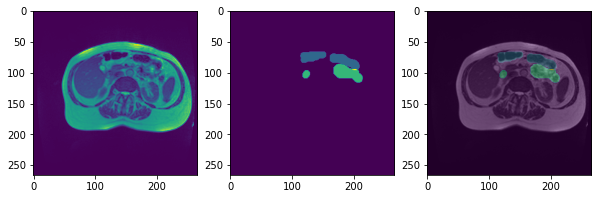

array([1277., 1960.,    0.], dtype=float32)

In [17]:
# Show the original image

df_row = df_train.loc[df_train['case_day'] == case_day].iloc[0]
image_path = glob.glob(df_row['image_path'] + f'/slice_{str(slice_num).zfill(4)}_*.png')[0]
image = plt.imread(image_path)
mask = load_mask(df_row['mask_path'])[:, :, :, slice_num-1]
mask[1] *= 2
mask[2] *= 3
mask_sum = mask.sum(axis=0)
fig, ax = plt.subplots(1,3,figsize=(10,6))
ax[0].imshow(image)
ax[1].imshow(mask_sum)
ax[2].imshow(image,'gray')
ax[2].imshow(mask_sum, alpha=0.5)
plt.show()
mask.sum(axis=(1,2))

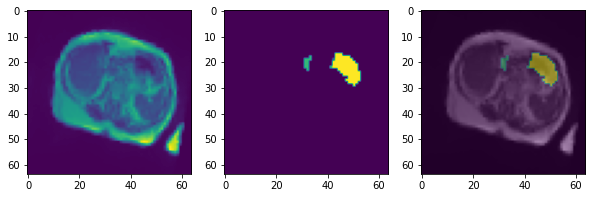

tensor([  1.,  24., 252.])

In [18]:
# Show trnsformed image
resized_slice_num = slice_num * CFG.image_size[2] // len(glob.glob(df_row['image_path'] + f'/slice_*.png')) 
image = subject['scan'][tio.DATA][0][:,:, resized_slice_num -1]
mask = subject['label'][tio.DATA][:,:,:, resized_slice_num - 1]
mask[1] *= 2
mask[2] *= 3
mask_sum = mask.sum(axis=0)
fig, ax = plt.subplots(1,3,figsize=(10,6))
ax[0].imshow(image)
ax[1].imshow(mask_sum)
ax[2].imshow(image,'gray')
ax[2].imshow(mask_sum, alpha=0.5)
plt.show()
mask.sum(axis=(1,2))

## Build Model

In [19]:
def get_segmtation_indices(mask):
    """
    :mask: (C x W x H x D) Tensor of the probability map of the estimation.
    :return: List of List of Tensors of the Ground Truth points.
                   The outer most list must be of size B as in prob_map.
                   The second outer most list must be of size C.
                   Each element in the second outer most list must be a 2D Tensor,
                   where each row is the (x, y, z), i.e, (col, row, depth) of a GT point.
    """
    num_classes = mask.size()[0]
    mask_indices = []
    for i in range(num_classes):
        mask_indices.append((mask[i] > 0).nonzero())
    
    return mask_indices
        

def double_conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv3d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True),
    )

class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, features =[64, 128, 256, 512]):
        super(UNet3D, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)

        #down part of UNet
        for feature in features:
            self.downs.append(double_conv_block(in_channels, feature))
            in_channels = feature

        #upsample part of UNet
        for feature in reversed(features):
            self.ups.append(
              nn.ConvTranspose3d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(double_conv_block(feature*2, feature))

        self.bottleneck = double_conv_block(features[-1], features[-1]*2)
        self.final_conv = nn.Sequential(nn.Conv3d(features[0], out_channels, kernel_size=1),  nn.Sigmoid())

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)


        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            # if x.shape != skip_connection.shape:
            #     x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [20]:
def build_model():
    model = UNet3D()
    model.to(CFG.device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

## Loss

In [21]:
def _assert_no_grad(variables_list):
    for variables in variables_list:
        for var in variables:
            assert not var.requires_grad, \
                "nn criterions don't compute the gradient w.r.t. targets - please " \
                "mark these variables as volatile or not requiring gradients"

class DiceLoss(torch.nn.Module):
    def __init__(self, num_classes):
        self.num_classes=num_classes
        super(DiceLoss, self).__init__()
    def forward(self, pred, target):
        batch_size = pred.shape[0]
        smooth = 1.
        iflat = pred.contiguous().view(batch_size, -1)
        tflat = target.contiguous().view(batch_size, -1)
        intersection = (iflat * tflat).sum(-1)
        A_sum = torch.sum(iflat * iflat, -1)
        B_sum = torch.sum(tflat * tflat, -1)
        return (1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )).mean()


class WeightedHausdorffLoss(torch.nn.Module):
    def __init__(self, num_classes, resized_shape, alpha=-1.0, return_by_class=False, device=torch.device('cpu')):
        self.alpha = alpha
        self.return_by_class = return_by_class
        self.width, self.height, self.depth = resized_shape
        self.num_classes = num_classes
        self.resized_size = torch.tensor(
            resized_shape,
            dtype=torch.get_default_dtype(), 
            device=device
        )
        self.n_pixels = np.prod(resized_shape)
        
        self.all_pixel_locations = torch.from_numpy(
            np.indices(resized_shape, dtype=np.int32).reshape(3,-1).transpose()
        ).to(device=device, dtype=torch.get_default_dtype())
        super(WeightedHausdorffLoss, self).__init__()
        
    def forward(self, prob_map, gt, orig_sizes):
        """
        Compute the Weighted Hausdorff Distance function
        between the estimated probability map and ground truth points.
        The output is the WHD averaged through all the batch.
        :param prob_map: (B x C x W x H x D) Tensor of the probability map of the estimation.
                         B is batch size, C is number of classes, H is height, W is width and D is depth.
                         Values must be between 0 and 1.
        :param gt: List of List of Tensors of the Ground Truth points.
                   The outer most list must be of size B as in prob_map.
                   The second outer most list must be of size C.
                   Each element in the second outer most list must be a 2D Tensor,
                   where each row is the (x, y, z), i.e, (col, row, depth) of a GT point.
        :param orig_sizes: Bx3 Tensor containing the size
                           of the original images.
                           B is batch size.
                           The size must be in (width, height, depth) format.
        :return: Single-scalar Tensor with the Weighted Hausdorff Distance.
                 If self.return_2_terms=True, then return a tuple containing
                 the two terms of the Weighted Hausdorff Distance.
        """

        _assert_no_grad(gt)

        assert prob_map.dim() == 5, 'The probability map shape must be (B x C x W x H x D)'
        assert prob_map.size()[1:5] == (self.num_classes, self.width, self.height, self.depth), \
        f'prob_map size is {prob_map.size()[1:5]}, it must have size {(self.num_classes, self.width, self.height, self.depth)}'

        batch_size = prob_map.shape[0]
        assert batch_size == len(gt)

        distances_by_class = [[] for _ in range(self.num_classes)]
    
        for batch_index in range(batch_size):
            orig_size_b = orig_sizes[batch_index, :]
            norm_factor = (orig_size_b/self.resized_size)
            max_dist = (orig_size_b ** 2).sum().sqrt()
            for class_index in range(self.num_classes):
                # One by one
                prob_map_b = prob_map[batch_index, class_index]
                gt_b = gt[batch_index][class_index]
                
                n_gt_pts = gt_b.size()[0]

                # Corner case: no GT points
                if gt_b.size()[0] == 0 or ((gt_b < 0).all().item() == 0):
                    # term_1 = max_dist
                    # term_2 = 0
                    distances_by_class[class_index].append(torch.tensor([1.0], dtype=torch.get_default_dtype()))
                    continue

                # Pairwise distances between all possible locations and the GTed locations
                n_gt_pts = gt_b.size()[0]
                
                # normalized_x has shape (width * height * depth, 3)
                # normalized_y has shape (number of masked points, 3)
                normalized_x = norm_factor * self.all_pixel_locations
                normalized_y = norm_factor * gt_b

                # normalized_x.unsqueeze(1) has shape (width * height * depth, 1, 3)
                # normalized_y.unsqueeze(0) has shape (1, number of true segmented points, 3)
                # diff has shape (width * height * depth, number of true segmented points, 3)
                diffs = normalized_x.unsqueeze(1) - normalized_y.unsqueeze(0)
                
                # distances has shape (width * height * depth, number of true segmented points)
                # normalize the distance with max distance 
                distance_matrix = torch.sum(diffs ** 2, -1).sqrt() / max_dist

                # Reshape probability map as a long column vector,
                # and prepare it for multiplication
                p = prob_map_b.view(prob_map_b.nelement())
                total_x_weight = p.sum()

                # Weighted Hausdorff Distance
                term_1 = (1 / (total_x_weight + 1e-6)) * torch.sum(p * torch.min(distance_matrix, 1)[0])
                
                p = p.view(-1, 1)
                weighted_distance_matrix = (1 - p) + p*distance_matrix
                
                # get generalized mean
                generalized_mean = torch.mean((weighted_distance_matrix + 1e-6)**self.alpha, 0)**(1./self.alpha)
                term_2 = torch.mean(generalized_mean)
                
                result = term_1 + term_2
                distances_by_class[class_index].append(result)

        result = torch.stack(
            [distances_by_class[class_index][batch_index] for batch_index in range(batch_size) for class_index in range(self.num_classes)]
        ).view(batch_size, self.num_classes)
        
        if self.return_by_class:
            return (1 - result).mean(dim=0) 

        return (1 - result.mean(dim=1)).mean()

## Test Run

## Train

In [22]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch, whf_loss):
    model.train()
    dice_loss = DiceLoss(3)
    scaler = amp.GradScaler()
    
    dataset_size = 0
    running_loss = 0.0
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Train ')
    
    for step, subjects_batch in pbar:
        images = subjects_batch['scan'][tio.DATA]
        masks = subjects_batch['label'][tio.DATA]
        original_sizes = subjects_batch['original_size']
        original_sizes = torch.stack(subjects_batch['original_size']).transpose(0,1)
        case_days = subjects_batch['case_day']
        
        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        original_sizes = original_sizes.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        segmentation_indices = []
        for i in range(batch_size):
            class_segmentation_indices = [item.to(CFG.device) for item in get_segmtation_indices(masks[i])]
            segmentation_indices.append(class_segmentation_indices)
        
        with amp.autocast(enabled=True):
            y_preds = model(images)
            loss = 0.4 * dice_loss(y_preds, masks) + 0.6 * whf_loss(y_preds, segmentation_indices, original_sizes)
            loss   = loss / CFG.n_accumulate
            
        scaler.scale(loss).backward()
    
        if (step + 1) % CFG.n_accumulate == 0:
            scaler.step(optimizer)
            scaler.update()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_mem=f'{mem:0.2f} GB')
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss

In [23]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3,4), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3, 4), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch, whf_loss):
    model.eval()
    dice_loss = DiceLoss(3)
    
    dataset_size = 0
    running_loss = 0.0
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Valid ')
   
    for step, subjects_batch in pbar:
        images = subjects_batch['scan'][tio.DATA]
        masks = subjects_batch['label'][tio.DATA]
        original_sizes = subjects_batch['original_size']
        original_sizes = torch.stack(subjects_batch['original_size']).transpose(0,1)
        case_days = subjects_batch['case_day']

        images = images.to(device, dtype=torch.float)
        masks  = masks.to(device, dtype=torch.float)
        original_sizes = original_sizes.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        
        segmentation_indices = []
        for i in range(batch_size):
            class_segmentation_indices = [item.to(CFG.device) for item in get_segmtation_indices(masks[i])]
            segmentation_indices.append(class_segmentation_indices)
        
        y_preds  = model(images)
        loss = 0.4 * dice_loss(y_preds, masks) + 0.6 * whf_loss(y_preds, segmentation_indices, original_sizes)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        # y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_preds).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_preds).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

In [24]:
def run_training(fold, model, whf_loss, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    # wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_dice      = -np.inf
    best_epoch     = -1
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CFG.device, epoch=epoch, whf_loss=whf_loss)
        
        val_loss, val_scores = valid_one_epoch(model, valid_loader, 
                                                 device=CFG.device, 
                                                 epoch=epoch, whf_loss=whf_loss)
        val_dice, val_jaccard = val_scores
    
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(val_loss)
        history['Valid Dice'].append(val_dice)
        history['Valid Jaccard'].append(val_jaccard)
        
        # Log the metrics
        """
        wandb.log({"Train Loss": train_loss, 
                   "Valid Loss": val_loss,
                   "Valid Dice": val_dice,
                   "Valid Jaccard": val_jaccard,
                   "LR":scheduler.get_last_lr()[0]})
        """
        print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
        
        # deep copy the model
        if val_dice >= best_dice:
            print(f"Valid Score Improved ({best_dice:0.4f} ---> {val_dice:0.4f})")
            best_dice    = val_dice
            best_jaccard = val_jaccard
            best_epoch   = epoch
            """
            run.summary["Best Dice"]    = best_dice
            run.summary["Best Jaccard"] = best_jaccard
            run.summary["Best Epoch"]   = best_epoch
            """
            best_model_wts = copy.deepcopy(model.state_dict())
            save_path = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), save_path)
            # Save a model file from the current directory
            # wandb.save(PATH)
            print(f"Model Saved")
            
        last_model_wts = copy.deepcopy(model.state_dict())
        model_path = f"last_epoch-{fold:02d}.bin"
        torch.save(model.state_dict(), model_path)
            
        print(); print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Score: {:.4f}".format(best_jaccard))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [25]:
def fetch_scheduler(optimizer):
    if CFG.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CFG.T_max, 
                                                   eta_min=CFG.min_lr)
    elif CFG.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CFG.T_0, 
                                                             eta_min=CFG.min_lr)
    elif CFG.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                   mode='min',
                                                   factor=0.1,
                                                   patience=7,
                                                   threshold=0.0001,
                                                   min_lr=CFG.min_lr,)
    elif CFG.scheduer == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CFG.scheduler == None:
        return None
        
    return scheduler

In [26]:
model = build_model()
whf_loss = WeightedHausdorffLoss(3, CFG.image_size, alpha=-1.0, device=CFG.device)
optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
scheduler = fetch_scheduler(optimizer)

In [27]:
for fold in range(1):
    print(f'#'*15)
    print(f'### Fold: {fold}')
    print(f'#'*15)
    """
    run = wandb.init(project='uw-maddison-gi-tract', 
                     config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                     anonymous=anonymous,
                     name=f"fold-{fold}|dim-{CFG.img_size[0]}x{CFG.img_size[1]}|model-{CFG.model_name}",
                     group=CFG.comment,
                    )
    """
    train_loader, valid_loader = prepare_loaders(df_train, fold=fold, debug=CFG.debug)
    model     = build_model()
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.wd)
    scheduler = fetch_scheduler(optimizer)
    model, history = run_training(fold, model, whf_loss, optimizer, scheduler,
                                  device=CFG.device,
                                  num_epochs=CFG.epochs)
    """
    run.finish()
    display(ipd.IFrame(run.url, width=1000, height=720))
    """

###############
### Fold: 0
###############
cuda: NVIDIA GeForce RTX 2080 Ti

Epoch 1/15

Valid : 100%|████████████████████████| 55/55 [01:04<00:00,  1.17s/it, gpu_memory=2.13 GB, lr=0.00200, valid_loss=0.3424]


Valid Dice: 0.1211 | Valid Jaccard: 0.0694
Valid Score Improved (-inf ---> 0.1211)
Model Saved


Epoch 2/15

Valid : 100%|████████████████████████| 55/55 [01:05<00:00,  1.19s/it, gpu_memory=2.48 GB, lr=0.00200, valid_loss=0.3138]


Valid Dice: 0.1314 | Valid Jaccard: 0.0798
Valid Score Improved (0.1211 ---> 0.1314)
Model Saved


Epoch 3/15

Valid : 100%|████████████████████████| 55/55 [01:03<00:00,  1.16s/it, gpu_memory=2.53 GB, lr=0.00200, valid_loss=0.2932]


Valid Dice: 0.1772 | Valid Jaccard: 0.1070
Valid Score Improved (0.1314 ---> 0.1772)
Model Saved


Epoch 4/15

Valid : 100%|████████████████████████| 55/55 [01:04<00:00,  1.17s/it, gpu_memory=2.49 GB, lr=0.00200, valid_loss=0.2754]


Valid Dice: 0.2271 | Valid Jaccard: 0.1441
Valid Score Improved (0.1772 ---> 0.2271)
Model Saved


Epoch 5/15

Valid : 100%|████████████████████████| 55/55 [01:03<00:00,  1.15s/it, gpu_memory=2.51 GB, lr=0.00200, valid_loss=0.2592]


Valid Dice: 0.2569 | Valid Jaccard: 0.1655
Valid Score Improved (0.2271 ---> 0.2569)
Model Saved


Epoch 6/15

Valid : 100%|████████████████████████| 55/55 [01:03<00:00,  1.16s/it, gpu_memory=2.53 GB, lr=0.00200, valid_loss=0.2995]


Valid Dice: 0.1928 | Valid Jaccard: 0.1241


Epoch 7/15

Valid : 100%|████████████████████████| 55/55 [01:03<00:00,  1.16s/it, gpu_memory=2.49 GB, lr=0.00200, valid_loss=0.2990]


Valid Dice: 0.1857 | Valid Jaccard: 0.1139


Epoch 8/15

Valid : 100%|████████████████████████| 55/55 [01:03<00:00,  1.15s/it, gpu_memory=2.53 GB, lr=0.00200, valid_loss=0.2676]


Valid Dice: 0.2537 | Valid Jaccard: 0.1634


Epoch 9/15

Valid : 100%|████████████████████████| 55/55 [01:03<00:00,  1.15s/it, gpu_memory=2.49 GB, lr=0.00200, valid_loss=0.2842]


Valid Dice: 0.2193 | Valid Jaccard: 0.1419


Epoch 10/15

Valid : 100%|████████████████████████| 55/55 [01:04<00:00,  1.18s/it, gpu_memory=2.53 GB, lr=0.00200, valid_loss=0.2714]


Valid Dice: 0.2322 | Valid Jaccard: 0.1550


Epoch 11/15

Valid : 100%|████████████████████████| 55/55 [01:02<00:00,  1.13s/it, gpu_memory=2.49 GB, lr=0.00200, valid_loss=0.2702]


Valid Dice: 0.2597 | Valid Jaccard: 0.1721
Valid Score Improved (0.2569 ---> 0.2597)
Model Saved


Epoch 12/15

Valid : 100%|████████████████████████| 55/55 [01:00<00:00,  1.11s/it, gpu_memory=2.53 GB, lr=0.00200, valid_loss=0.2599]


Valid Dice: 0.2690 | Valid Jaccard: 0.1765
Valid Score Improved (0.2597 ---> 0.2690)
Model Saved


Epoch 13/15

Valid : 100%|████████████████████████| 55/55 [01:01<00:00,  1.12s/it, gpu_memory=2.49 GB, lr=0.00200, valid_loss=0.2857]


Valid Dice: 0.2101 | Valid Jaccard: 0.1356


Epoch 14/15

Valid : 100%|████████████████████████| 55/55 [01:02<00:00,  1.14s/it, gpu_memory=2.49 GB, lr=0.00200, valid_loss=0.2689]


Valid Dice: 0.2400 | Valid Jaccard: 0.1618


Epoch 15/15

Valid : 100%|████████████████████████| 55/55 [01:03<00:00,  1.16s/it, gpu_memory=2.49 GB, lr=0.00200, valid_loss=0.3075]


Valid Dice: 0.1597 | Valid Jaccard: 0.1057


Training complete in 1h 17m 40s
Best Score: 0.1765


In [ ]:
test_dataset = tio.SubjectsDataset(
        [get_subject(row['case_day'], row['image_path'], row['mask_path']) for _, row in df_train.query("fold==0").sample(frac=1.0).iterrows()], 
        transform=data_transforms['valid']
    )

test_loader  = DataLoader(test_dataset, batch_size=4, 
                          num_workers=0, shuffle=False, pin_memory=True)
subjects = next(iter(test_loader))
images = subjects['scan'][tio.DATA]
images = images.to(CFG.device, dtype=torch.float)
masks = subjects['label'][tio.DATA]
masks = masks.to(CFG.device, dtype=torch.float)

preds = []
for fold in range(1):
    model = load_model(f"best_epoch-{fold:02d}.bin")
    with torch.no_grad():
        pred = model(images)
        pred = (pred>0.5).double()
    preds.append(pred)
    
images  = images.cpu().detach()
masks = masks.cpu().detach()
preds = torch.mean(torch.stack(preds, dim=0), dim=0).cpu().detach()

In [ ]:
images.shape

In [ ]:
masks.shape

In [69]:
preds.shape

torch.Size([4, 3, 64, 64, 16])

In [70]:
def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#     img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = ["Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

def plot_batch(imgs, msks, depth, size=3):
    plt.figure(figsize=(5*5, 5))
    for idx in range(size):
        plt.subplot(1, 5, idx+1)
        img = imgs[idx, :, :, :, depth].permute((1, 2, 0)).numpy()*255.0
        img = img.astype('uint8')
        msk = msks[idx, :, :, :, depth].permute((1, 2, 0)).numpy()*255.0
        show_img(img, msk)
    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


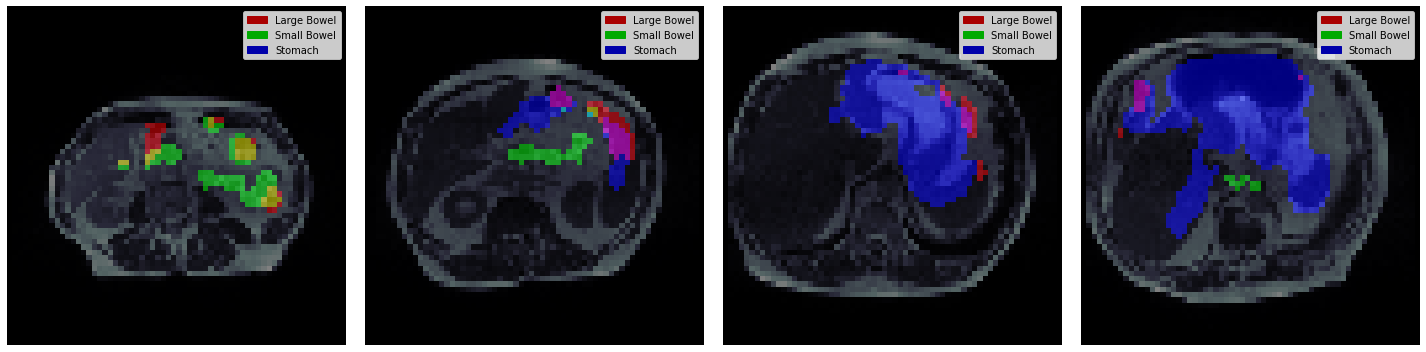

In [71]:
plot_batch(images, preds, depth=8, size=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


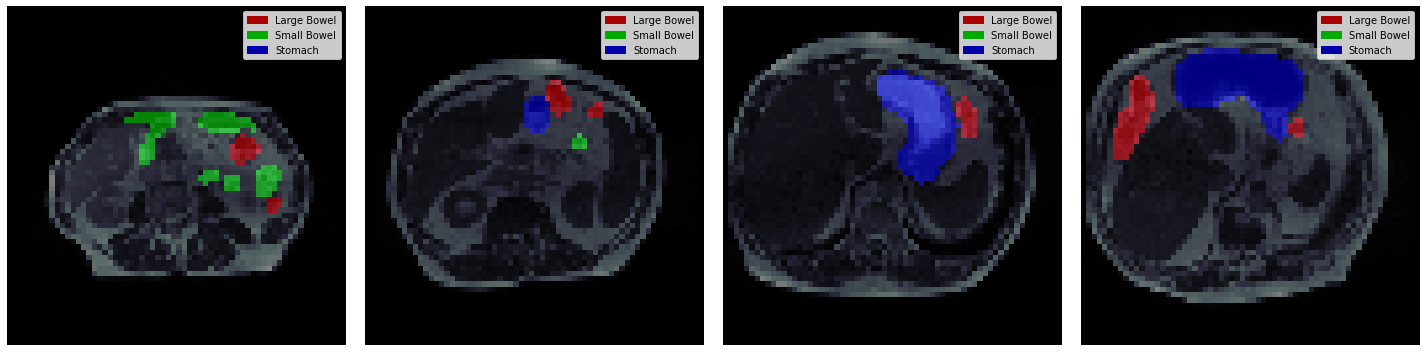

In [72]:
plot_batch(images, masks, depth=8, size=4)